
# Implementing DiffPIR

In this tutorial, we revisit the implementation of the DiffPIR diffusion algorithm for image reconstruction from
[Zhou et al.](https://arxiv.org/abs/2305.08995). The full algorithm is implemented in
:class:`deepinv.sampling.diffusion.DiffPIR`.


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import os
# Set GPU ID
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import deepinv as dinv
# from deepinv.utils.plotting import plot
from deepinv.optim.data_fidelity import L2

## Generate an inverse problem

We first generate a deblurring problem with the Butterly image. We use a square blur kernel of size 5x5 and
Gaussian noise with standard deviation 12.75/255.0.



In [2]:
from deepinv.utils.demo import load_url_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

url = (
    "https://mycore.core-cloud.net/index.php/s/9EzDqcJxQUJKYul/"
    "download?path=%2Fdatasets&files=butterfly.png"
)
x_true = load_url_image(url=url, img_size=256).to(device)
x = x_true.clone().to(device)

sigma = 12.75 / 255.0  # noise level

physics = dinv.physics.BlurFFT(
    img_size=(3, x.shape[-2], x.shape[-1]),
    filter=torch.ones((1, 1, 5, 5), device=device) / 25,
    device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=sigma),
)

y = physics(x)


In [3]:
x.shape

torch.Size([1, 3, 256, 256])

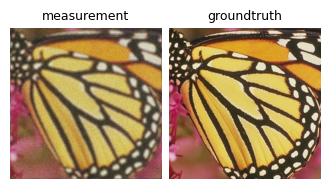

In [4]:
from deepinv.utils.plotting import plot
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

imgs = [y, x_true]
titles=["measurement", "groundtruth"]
plot(
    imgs,
    titles=titles,
)




## The DiffPIR algorithm

Now that the inverse problem is defined, we can apply the DiffPIR algorithm to solve it. The DiffPIR algorithm is
a diffusion algorithm that alternates between a denoising step, a proximal step and a reverse diffusion sampling step.
The algorithm writes as follows, for $t$ decreasing from $T$ to $1$:

\begin{align}\begin{equation*}
        \begin{aligned}
        x_{0}^{t} &= \left(x_t + (1 - \overline{\alpha}_t)\mathbf{s}_\theta(x_t,t))\right)/\sqrt{\overline{\alpha}_t} \\
        \widehat{x}_{0}^{t} &= \operatorname{prox}_{2 f(y, \cdot) /{\rho_t}}(x_{0}^{t}) \\
        \widehat{\varepsilon} &= \left(x_t - \sqrt{\overline{\alpha}_t} \,\, \widehat{x}_{0}^t\right)/\sqrt{1-\overline{\alpha}_t} \\
        \varepsilon_t &= \mathcal{N}(0, \mathbf{I}) \\
        x_{t-1} &= \sqrt{\overline{\alpha}_t} \,\, \widehat{x}_{0}^t + \sqrt{1-\overline{\alpha}_t} \left(\sqrt{1-\zeta} \,\, \widehat{\varepsilon} + \sqrt{\zeta} \,\, \varepsilon_t\right),
        \end{aligned}
        \end{equation*}\end{align}

where $\mathbf{s}_\theta$ is a denoising network, $\mathcal{N}(0, \mathbf{I})$ is a Gaussian noise
with zero mean and unit variance, and $\zeta$ is a parameter that controls the amount of noise added at each
iteration. The parameters $(\overline{\alpha}_t)_{0\leq t\leq T}$ and $(\rho_t)_{0\leq t\leq T}$ are
sequences of positive numbers, which we will detail later on.

Let us now implement each step of this algorithm.



## Denoising step

In this section, we show how to use the denoising diffusion model from DiffPIR.
The denoising step is implemented by a denoising network conditioned on the noise power. The authors
of DiffPIR use a U-Net architecture, which can be loaded as follows:



In [5]:
from deepinv.models import get_diffpir_model_defaults

MODEL_PATH_DIFUNC = "/disk/xray99/tl3/pretrained_diffusions/diffpir_pretrained_models/256x256_diffusion_uncond.pt"
MODEL_CONFIG_DIFUC = dict(
    model_path=MODEL_PATH_DIFUNC,
    model_name="256x256_diffusion_uncond.pt",
    num_channels=256,
    num_res_blocks=2,
    attention_resolutions="8,16,32",
)

MODEL_PATH_FFHQ = "/disk/xray99/tl3/pretrained_diffusions/diffpir_pretrained_models/diffusion_ffhq_10m.pt"
MODEL_CONFIG_FFHQ = dict(
    model_path=MODEL_PATH_FFHQ,
    model_name="diffusion_ffhq_10m.pt",
    num_channels=128,
    num_res_blocks=1,
    attention_resolutions="16",
)

# model = get_diffpir_model_defaults(model_config=MODEL_CONFIG_FFHQ, device=device)
model = get_diffpir_model_defaults(model_config=MODEL_CONFIG_DIFUC, device=device)


Now, recall that the forward diffusion can be rewritten as, for all $t$,

\begin{align}\begin{equation*}
        x_t = \sqrt{\overline{\alpha}_t} \widehat{x}_{0} + \sqrt{1-\overline{\alpha}_t} \varepsilon_t.
        \end{equation*}\end{align}

In this context, the denoising diffusion model $s_theta(x, t)$ is trained to approximate $\varepsilon_t$
from $x_t$ and $t$. The denoised image thus writes:

\begin{align}\begin{equation*}
        \widehat{x}_{0} \approx \frac{1}{\sqrt{\overline{\alpha}_t}}x_t-(\frac{1}{\sqrt{\overline{\alpha}_t}}-1) \mathbf{s}_\theta(x_t, t)
        \end{equation*}\end{align}

Before being able to use the pretrained model, we need to define the sequence
$(\overline{\alpha}_t)_{0\leq t\leq T}$. In practice, we will not use $\overline{\alpha}_t$ directly,
but rather other sequences directly deriving from it (e.g. $(1/\sqrt{\overline{\alpha}_t})_{0\leq t\leq T}$).
The following function returns these sequences:




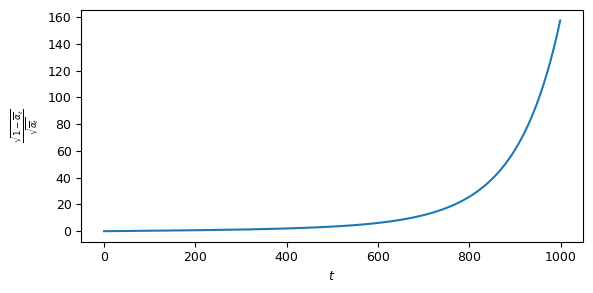

In [6]:
num_train_timesteps = 1000  # Number of timesteps used during training


def get_alpha_beta(
    beta_start=0.1 / 1000, beta_end=20 / 1000, num_train_timesteps=num_train_timesteps
):
    betas = np.linspace(beta_start, beta_end, num_train_timesteps, dtype=np.float32)
    betas = torch.from_numpy(betas).to(device)
    alphas = 1.0 - betas
    alphas_cumprod = np.cumprod(alphas.cpu(), axis=0)  # This is \overline{\alpha}_t

    # Useful sequences deriving from alphas_cumprod
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_1m_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
    reduced_alpha_cumprod = torch.div(
        sqrt_1m_alphas_cumprod, sqrt_alphas_cumprod
    )  # equivalent noise sigma on image
    sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / alphas_cumprod)
    sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / alphas_cumprod - 1)

    return (
        sqrt_1m_alphas_cumprod,
        reduced_alpha_cumprod,
        sqrt_alphas_cumprod,
        sqrt_recip_alphas_cumprod,
        sqrt_recipm1_alphas_cumprod,
        betas,
    )


(
    sqrt_1m_alphas_cumprod,
    reduced_alpha_cumprod,
    sqrt_alphas_cumprod,
    sqrt_recip_alphas_cumprod,
    sqrt_recipm1_alphas_cumprod,
    betas,
) = get_alpha_beta()

# plot the alpha sequence
plt.rcParams.update({"font.size": 9})
plt.figure(figsize=(6, 3))
plt.plot(reduced_alpha_cumprod)
plt.ylabel(r"$\frac{\sqrt{1-\overline{\alpha}_t}}{\sqrt{\overline{\alpha}_t}}$")
plt.xlabel(r"$t$")
plt.tight_layout()
plt.show()

Now that we have the sequence of interest, there remains to link noise power to the timestep. The following function
returns the timestep corresponding to a given noise power.



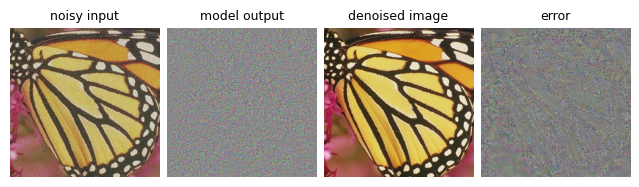

In [7]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


# We can now apply the model to a noisy image. We first generate a noisy image
x_noisy = x_true + torch.randn_like(x_true) * sigma
x_noisy = x_noisy.to(device)

# Next, we compute the timestep corresponding to the noise power sigma
t_i = find_nearest(reduced_alpha_cumprod.cpu().numpy(), sigma * 2)

# Eventually, we apply the model to the noisy image
x_noisy = 2 * x_noisy - 1  # Rescale to [-1, 1] (the model expects this range)
noise_est = model(x_noisy, torch.tensor([t_i]).to(y.device))

# The model outputs a tensor of shape (1, 6, H, W), where the last three channels correspond to a standard
# deviation map. We only keep the first three channels, which correspond to the point estimate.
noise_est = noise_est[:, :3, ...]

# Compute the denoised image
den = (
    sqrt_recip_alphas_cumprod[t_i] * x_noisy
    - sqrt_recipm1_alphas_cumprod[t_i] * noise_est
)

# Rescale to [0, 1]
x_noisy = x_noisy * 0.5 + 0.5
noise_est = noise_est * 0.5 + 0.5
den = den * 0.5 + 0.5

imgs = [x_noisy, noise_est, den, den - x_true]
plot(
    imgs,
    titles=["noisy input", "model output", "denoised image", "error"],
)

In [8]:
x_true.device

device(type='cuda', index=0)

## Data fidelity step

The data fidelity step is easily implemented in deepinv. We simply need to define a data fidelity function and use
its prox attribute. For instance:



In [9]:
from deepinv.optim.data_fidelity import IndicatorL2



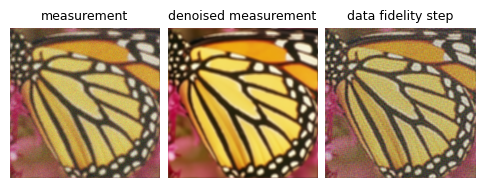

In [10]:
data_fidelity = L2()

# data_fidelity = IndicatorL2(radius=sigma)

# In order to take a meaningful data fidelity step, it is best if we apply it to denoised measurements.
# First, rescale the measurements in [-1, 1] and denoise it
y_scaled = 2 * y - 1
noise_est_sample_var = model(y_scaled, torch.tensor([t_i]).to(y.device))
noise_est = noise_est_sample_var[:, :3, ...]
y_denoised_scaled = (
    sqrt_recip_alphas_cumprod[t_i] * y_scaled
    - sqrt_recipm1_alphas_cumprod[t_i] * noise_est
)

# Rescale back to [0, 1]
y_denoised = (y_denoised_scaled + 1) / 2

# Next, apply the proximity operator of the data fidelity term (this is the data fidelity step). In the algorithm,
# the regularization parameter is carefully chosen. Here, for simplicity, we set it to 1/sigma.
x_prox = data_fidelity.prox(y_denoised, y, physics, gamma=1 / sigma)

imgs = [y, y_denoised, x_prox]
plot(
    imgs,
    titles=["measurement", "denoised measurement", "data fidelity step"],
)

## Sampling step

The last step to be implemented is the DiffPIR sampling step and this can be computed in two steps.
Firstly, we need to compute the effective noise in the estimated reconstruction, i.e. the residual between the previous
reconstruction and the data fidelity step. This is done as follows:



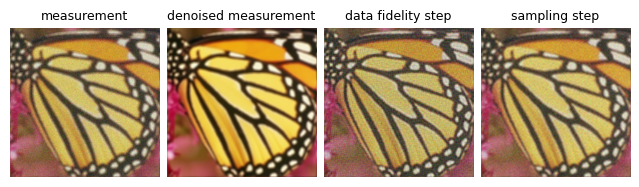

In [11]:
x_prox_scaled = 2 * x_prox - 1  # Rescale the output of the proximal step in [-1, 1]
eps = (y_scaled - sqrt_alphas_cumprod[t_i] * x_prox_scaled) / sqrt_1m_alphas_cumprod[
    t_i
]

# (notice the rescaling)
#
# Secondly, we need to perform the sampling step, which is a linear combination between the estimated noise and
# the realizations of a Gaussian white noise. This is done as follows:
zeta = 0.3
x_sampled_scaled = (
    sqrt_alphas_cumprod[t_i - 1] * x_prox_scaled
    + np.sqrt(1 - zeta) * (torch.sqrt(sqrt_1m_alphas_cumprod[t_i - 1] ** 2) * eps)
    + np.sqrt(zeta) * sqrt_1m_alphas_cumprod[t_i - 1] * torch.randn_like(x)
)

x_sampled = (x_sampled_scaled + 1) / 2

imgs = [y, y_denoised, x_prox, x_sampled]
plot(
    imgs,
    titles=[
        "measurement",
        "denoised measurement",
        "data fidelity step",
        "sampling step",
    ],
)

## Putting it all together: the DiffPIR algorithm

We can now put all the steps together and implement the DiffPIR algorithm. The only remaining step is to set the
noise schedule (i.e. the sequence of noise powers and regularization parameters) appropriately. This is done with the
following function:



In [25]:
max_iter = 100  # Maximum number of iterations of the DiffPIR algorithm

<div class="alert alert-info"><h4>Note</h4><p>We only use 30 steps to reduce the computational time of this example. As suggested by the authors of DiffPIR, the
  algorithm works best with ``max_iter = 100``.</p></div>




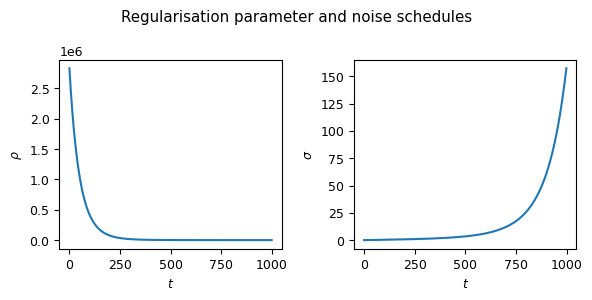

In [26]:
def get_noise_schedule(max_iter=max_iter, num_train_timesteps=num_train_timesteps):
    lambda_ = 7.0

    sigmas = []
    sigma_ks = []
    rhos = []
    for i in range(num_train_timesteps):
        sigmas.append(reduced_alpha_cumprod[num_train_timesteps - 1 - i])
        sigma_ks.append((sqrt_1m_alphas_cumprod[i] / sqrt_alphas_cumprod[i]))
        rhos.append(lambda_ * (sigma**2) / (sigma_ks[i] ** 2))
    rhos, sigmas = torch.tensor(rhos).to(device), torch.tensor(sigmas).to(device)

    seq = np.sqrt(np.linspace(0, num_train_timesteps**2, max_iter))
    seq = [int(s) for s in list(seq)]
    seq[-1] = seq[-1] - 1

    return rhos, sigmas, seq


rhos, sigmas, seq = get_noise_schedule()

# Plot the noise and regularization schedules
plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.plot(
    2 / rhos.detach().cpu().numpy()[::-1]
)  # Note that the regularization parameter is 2/rho and not rho
plt.xlabel(r"$t$")
plt.ylabel(r"$\rho$")
plt.subplot(122)
plt.plot(sigmas.detach().cpu().numpy()[::-1])
plt.xlabel(r"$t$")
plt.ylabel(r"$\sigma$")
plt.suptitle("Regularisation parameter and noise schedules")
plt.tight_layout()
plt.show()

Eventually, the DiffPIR algorithm is implemented as follows:




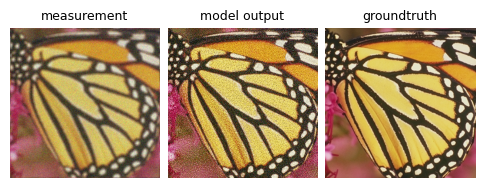

In [27]:
# Initialization
x = 2 * y - 1

for i in range(len(seq)):
    # Current noise level
    curr_sigma = sigmas[seq[i]].cpu().numpy()

    # time step associated with the noise level sigmas[i]
    t_i = find_nearest(reduced_alpha_cumprod, curr_sigma)

    # Denoising step
    noise_est_sample_var = model(x, torch.tensor([t_i]).to(y.device))
    noise_est = noise_est_sample_var[:, :3, ...]
    x0 = (
        sqrt_recip_alphas_cumprod[t_i] * x
        - sqrt_recipm1_alphas_cumprod[t_i] * noise_est
    )
    x0 = x0.clamp(-1, 1)

    if not seq[i] == seq[-1]:
        # Data fidelity step
        x0_p = x0 / 2 + 0.5
        x0_p = data_fidelity.prox(x0_p, y, physics, gamma=1 / (2 * rhos[t_i]))
        x0 = x0_p * 2 - 1

        # Sampling step
        t_im1 = find_nearest(
            reduced_alpha_cumprod, sigmas[seq[i + 1]].cpu().numpy()
        )  # time step associated with the next noise level
        eps = (x - sqrt_alphas_cumprod[t_i] * x0) / sqrt_1m_alphas_cumprod[
            t_i
        ]  # effective noise
        x = (
            sqrt_alphas_cumprod[t_im1] * x0
            + torch.sqrt(sqrt_1m_alphas_cumprod[t_im1] ** 2) * np.sqrt(1 - zeta) * eps
            + sqrt_1m_alphas_cumprod[t_im1] * np.sqrt(zeta) * torch.randn_like(x)
        )  # sampling


# Plotting the results
x = x / 2 + 0.5

imgs = [y, x, x_true]
plot(
    imgs,
    titles=["measurement", "model output", "groundtruth"],
)

## Directly using the DiffPIR model


In [28]:
from deepinv.sampling.diffusion import DiffPIR



In [38]:

diff_model = DiffPIR(
        model,
        data_fidelity,
        sigma=sigma,
        max_iter=max_iter,
        zeta=0.5,
        verbose=True,
        device=device,
    )




In [39]:


diff_post_sample = diff_model.forward(       
    y,
    physics=physics,
    sigma=sigma,
    seed=None,
    x_init=x_noisy,
)




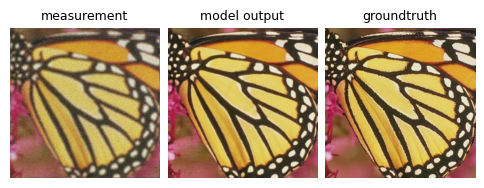

In [40]:
# Plotting the results
# diff_post_sample = diff_post_sample / 2 + 0.5

imgs = [y, diff_post_sample, x_true]
plot(
    imgs,
    titles=["measurement", "model output", "groundtruth"],
)

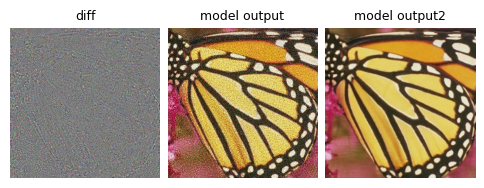

In [41]:
imgs_2 = [x - diff_post_sample, x, diff_post_sample]
titles_2 = ["diff", "model output", "model output2"]
plot(
    imgs_2,
    titles=titles_2,
)


In [33]:
imgs_2[0].detach().cpu().squeeze().numpy().shape

(3, 256, 256)

In [34]:
np.sum(abs((imgs_2[0].detach().cpu().squeeze().numpy())))

23518.266

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


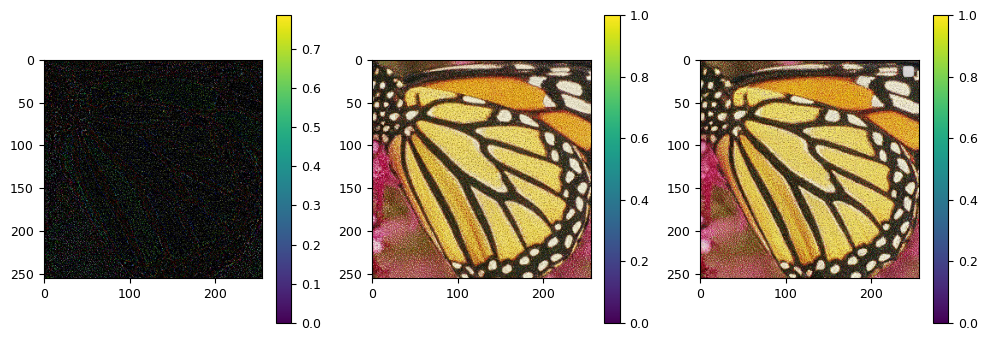

In [35]:
plt.figure(figsize=(12,4))

plt.subplot(131)
plt.imshow(np.moveaxis(imgs_2[0].detach().cpu().squeeze().numpy(), 0, 2), label=titles_2[0])
plt.colorbar()

plt.subplot(132)
plt.imshow(np.moveaxis(imgs_2[1].detach().cpu().squeeze().numpy(), 0, 2), label=titles_2[1])
plt.colorbar()

plt.subplot(133)
plt.imshow(np.moveaxis(imgs_2[2].detach().cpu().squeeze().numpy(), 0, 2), label=titles_2[2])
plt.colorbar()

plt.legend()
plt.show()


In [36]:
print(imgs_2[0].max())
print(imgs_2[0].min())


tensor(0.7861, device='cuda:0')
tensor(-0.8144, device='cuda:0')


In [37]:
print(imgs_2[1].max())
print(imgs_2[1].min())

print(imgs_2[2].max())
print(imgs_2[2].min())

tensor(1.0099, device='cuda:0')
tensor(-0.0169, device='cuda:0')
tensor(1.0126, device='cuda:0')
tensor(-0.0143, device='cuda:0')
